# 网格搜索预处理步骤与模型参数

我们可以利用管道将机器学习工作流程中的所有处理步骤封装成一个scikit-learn估计器。这么做的另一个好处在于，现在我们可以使用监督任务(比如回归或分类)的输出来调节预处理参数。前面,我们在应用岭回归之前使用了boston数据集的多项式特征。下面我们用一个管道来重复这个建模过程。管道包含3个步骤：缩放数据.计算多项式特征与岭回归：

In [1]:
import mglearn
boston = mglearn.datasets.load_boston()

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler  # 多项式特征
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

我们怎么知道选择几次多项式，或者是否选择多项式或交互项呢？理想情况下，我们希望根据分类结果来选择degree参数。我们可以利用管道搜索degree参数以及Ridge的 alpha 参数。为了做到这一点，我们要定义一个包含这两个参数的param_grid ,并用步骤名称作为前缀：

In [3]:
param_grid = {'polynomialfeatures__degree' : [1, 2, 3], 'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}

现在我们可以再次运行网格搜索：

In [4]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

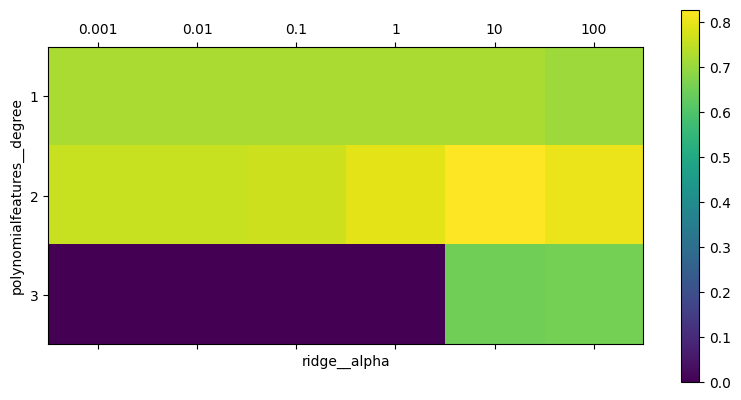

In [5]:
# 以多项式特征的次数和岭回归的alpha参数为坐标轴，绘制交叉验证平均分数的热图 
import matplotlib.pyplot as plt

# grid.cv_results_['mean_test_score']：这将检索网格搜索中每个超参数组合的平均交叉验证分数。
# 对象grid.cv_results_可能包含使用 scikit-learn GridSearchCV 或类似的超参数调整执行的网格搜索交叉验证的结果工具。
# /该对象是一个字典，存储有关不同超参数组合的模型交叉验证性能的各种信息。
# reshape(3, -1)：将数组重塑为具有 3 行和适当列数的 2D 网格。具体形状取决于网格搜索中超参数值的长度。
# vmin=0：将色标的最小值设置为 0。
# cmap="viridis"：指定用于为矩阵着色的颜色图。 “viridis”是一个感知上均匀的颜色图。
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])  # xticks设置刻度位置和标签
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()

从交叉验证的结果中可以看出，使用二次多项式很有用，但三次多项式的效果比一次或二次都要差很多。从找到的最佳参数中也可以看出这一点：

In [6]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


这个最佳参数对应的分数如下:

In [7]:
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

Test set score: 0.77


为了对比，我们运行一个没有多项式特征的网格搜索：

In [8]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


不使用多项式特征得到了明显更差的结果

同时搜索预处理参数与模型参数是一个非常强大的策略。但是要记住，GridSearchCV会尝试指定参数的所有可能组合因此，向网格中添加更多参数，需要构建的模型数量将呈指数增长。